In [1]:
from astropy.io import fits
from astropy import table
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import os
from astropy import wcs
from astropy.table import Table, hstack, Column
from spectral_cube import SpectralCube
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
### Paths to data files may need to be replaced depending on where you are storing your files
catalog = Table.read('./megacatalog_team_acc_final_say.fits')
cont_mosaic_hdu = fits.open('./CMZoom_continuum_pbcor.fits')
cat_mask = fits.getdata('./dendrogram_mask_pruned_rms3e6_k14_dv3_dd1_dp17_pp6_pm2_gal_02-02-20.fits')

cube_ID = 'G359.889-0.093'
### Clouds that I've done so far
#G359.889-0.093
#'G0.068-0.075'
#'G0.380+0.050'
#'G0.106-0.082'

#### Load in the cube for each transition
cube1_hdu = fits.open('./'+cube_ID+'.H2CO.218.2GHz.fits')
cube2_hdu = fits.open('./'+cube_ID+'.H2CO.218.5GHz.fits')
cube3_hdu = fits.open('./'+cube_ID+'.H2CO.218.8GHz.fits')

### delete problematic wcs flag
del cube1_hdu[0].header['TIMESYS']
del cube2_hdu[0].header['TIMESYS']
del cube3_hdu[0].header['TIMESYS']


In [4]:
### Construct WCS for continuum mosaic and cubes (should be the same for each cube)
cont_wcs = wcs.WCS(cont_mosaic_hdu[0])
cube1_wcs = wcs.WCS(cube1_hdu[0])
cube2_wcs = wcs.WCS(cube2_hdu[0])
cube3_wcs = wcs.WCS(cube3_hdu[0])

In [23]:
print(catalog['SF_final_say'][catalog['mask_num']==34])
print(catalog['leaf_ID'][catalog['mask_num']==34])

print(catalog['mask_num'][catalog['leaf_ID']=='G359.484-0.132a'])

SF_final_say
------------
         0.0
         0.0
         0.0
         1.0
         0.0
    leaf_ID    
---------------
G359.484-0.132d
G359.484-0.132e
G359.484-0.132b
G359.484-0.132a
G359.484-0.132c
mask_num
--------
      34


In [5]:
### In this cell, we identify pixels for each leaf in the cloud using the mask
### then convert those pixels to cube coordinates

cleaves = np.empty(0, dtype=int)
for i, leafi in enumerate(catalog['leaf_ID']): 
    if leafi.startswith(cube_ID[0:8]): 
        print(leafi, catalog['glon'][i], catalog['glat'][i])
        cleaves = np.append(arr=cleaves, values=catalog['index'][i])
print(cleaves)

if len(cleaves)==0:
    raise Exception("No leaves in cloud! Stop trying to make nothing spectra!")

leaf_avg_spectra_1 = np.empty((len(cleaves),cube1_hdu[0].header['NAXIS3']))
leaf_avg_spectra_2 = np.empty((len(cleaves),cube2_hdu[0].header['NAXIS3']))
leaf_avg_spectra_3 = np.empty((len(cleaves),cube3_hdu[0].header['NAXIS3']))

cube_only_leaf_ID = np.array([],dtype=str)
for i, leaf_index in enumerate(cleaves):
    leafi_pix_mosaic = np.where(cat_mask==leaf_index)
    leafi_pix_world = cont_wcs.pixel_to_world_values(leafi_pix_mosaic[1],leafi_pix_mosaic[0])
    leafi_pix_cube = cube1_wcs.world_to_pixel_values(leafi_pix_world[0],leafi_pix_world[1],0)[:-1]
    cube_only_leaf_ID = np.append(arr=cube_only_leaf_ID, values=catalog['leaf_ID'][catalog['index']==leaf_index])

    
    ### Now we create the average spectrum arrays for each channel and line
    avg_spectrum_1 = np.zeros(cube1_hdu[0].header['NAXIS3'])
    avg_spectrum_2 = np.zeros(cube2_hdu[0].header['NAXIS3'])
    avg_spectrum_3 = np.zeros(cube3_hdu[0].header['NAXIS3'])
    
    ### THIS NEXT PART ONLY WORKS IF THE THREE CUBES HAVE THE SAME WCS AND AXES!!!
    for j in range(cube1_hdu[0].header['NAXIS3']):
        leafpix_j_x = np.array(leafi_pix_cube[0],dtype=int)
        leafpix_j_y = np.array(leafi_pix_cube[1],dtype=int)
        avg_spectrum_1[j] = np.average(cube1_hdu[0].data[j,leafpix_j_y,leafpix_j_x])
        avg_spectrum_2[j] = np.average(cube2_hdu[0].data[j,leafpix_j_y,leafpix_j_x])
        avg_spectrum_3[j] = np.average(cube3_hdu[0].data[j,leafpix_j_y,leafpix_j_x])
    
    leaf_avg_spectra_1[i,:] = avg_spectrum_1
    leaf_avg_spectra_2[i,:] = avg_spectrum_2
    leaf_avg_spectra_3[i,:] = avg_spectrum_3

G359.889-0.093j -0.14764494096954195 -0.08737423607852954
G359.889-0.093q -0.14975960608626337 -0.08697606106113001
G359.889-0.093f -0.14488022162316838 -0.08665413878172
G359.889-0.093t -0.14308670957615277 -0.08609224349048568
G359.889-0.093u -0.1479001654155354 -0.08656693117510823
G359.889-0.093r -0.14594036205585326 -0.0858937361978555
G359.889-0.093a -0.1351524654750733 -0.08445236301544866
G359.889-0.093e -0.13161000364237907 -0.08457364829747174
G359.889-0.093p -0.13371373110157947 -0.0848315720127128
G359.889-0.093m -0.13729817094321106 -0.08196468642045943
G359.889-0.093h -0.13899990644176796 -0.08095105146780363
G359.889-0.093c -0.14211029308887646 -0.07873902024071315
G359.889-0.093d -0.12493487762731093 -0.07883664328317982
G359.889-0.093l -0.14945400314712742 -0.0775838789097135
G359.889-0.093k -0.1109776331107355 -0.07606805073435433
G359.889-0.093n -0.11639102209989005 -0.07528546653470967
G359.889-0.093s -0.11534350147002215 -0.07473631442164821
G359.889-0.093o -0.1173

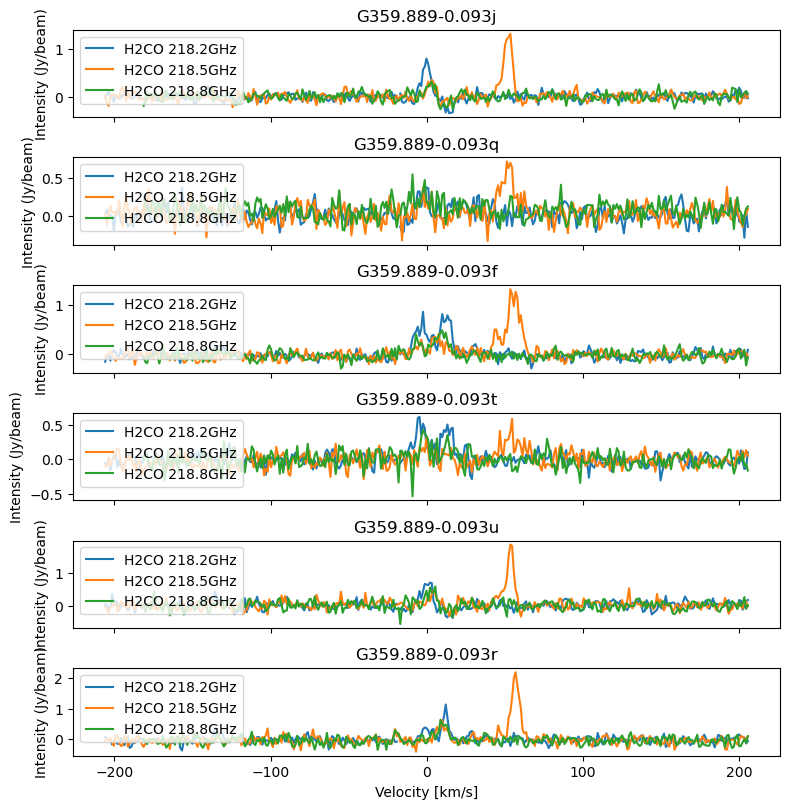

In [9]:
### Now we plot the spectra for each transition and leaf
spectral_x = np.linspace(cube1_hdu[0].header['CRVAL3'],
                         cube1_hdu[0].header['CDELT3']*(cube1_hdu[0].header['NAXIS3'])/2.,
                         cube1_hdu[0].header['NAXIS3'])

if cube1_hdu[0].header['CUNIT3']=='m/s' or cube2_hdu[0].header['CUNIT3']=='m/s' or cube3_hdu[0].header['CUNIT3']=='m/s':
    spectral_x = spectral_x/1000.
    
if len(leaf_avg_spectra_1[:,0]) > 6: num_spectra=6
else: num_spectra=len(leaf_avg_spectra_1[:,0])

fig, axes = plt.subplots(nrows=num_spectra,ncols=1,figsize=(8,8),sharex=True)
for i in range(num_spectra):
    ax = axes[i]
    ax.plot(spectral_x,leaf_avg_spectra_1[i,:], label='H2CO 218.2GHz')
    ax.plot(spectral_x,leaf_avg_spectra_2[i,:], label='H2CO 218.5GHz')
    ax.plot(spectral_x,leaf_avg_spectra_3[i,:], label='H2CO 218.8GHz')
    ax.set_title(cube_only_leaf_ID[i])
    ax.set_ylabel('Intensity (Jy/beam)')
    ax.legend(loc='upper left')
plt.tight_layout()
ax.set_xlabel('Velocity [km/s]')
plt.show()

In [48]:
#### In this cell, we construct a fits table using the binary table tools in astropy.table
### We construct a separate column for velocity and intensity for each leaf for each line.
### Create an empty column list to create the fits table
colList = []
line_IDs = ['218.2GHz','218.5GHz','218.8GHz']
### loop through each line
for j, line_ID in enumerate(line_IDs):
    ### loop through each 
    if line_ID=='218.2GHz': leaf_avg_spectra = leaf_avg_spectra_1
    elif line_ID=='218.5GHz': leaf_avg_spectra = leaf_avg_spectra_2
    elif line_ID=='218.8GHz': leaf_avg_spectra = leaf_avg_spectra_3
    for i, leaf_ID in enumerate(cube_only_leaf_ID):
        colList.append(fits.Column(name=leaf_ID+'_velocity_h2co_'+line_ID, format='1E', 
                                   array=spectral_x, unit='u.km/u.s'))
        colList.append(fits.Column(name=leaf_ID+'_intensity_h2co_'+line_ID, format='1E', 
                                   array=leaf_avg_spectra[i,:], unit='u.jy/u.beam'))

colDefs = fits.ColDefs(colList)
out_table_hdu = fits.BinTableHDU.from_columns(colDefs)
out_table_hdu.header['BMAJ'] = cube1_hdu[0].header['BMAJ']
out_table_hdu.header['BMIN'] = cube1_hdu[0].header['BMIN']



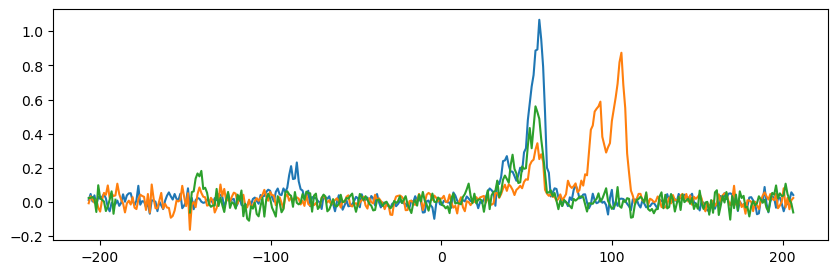

In [39]:
### plot output for a sample leaf just as a double check to make sure things are loading in properly (optional)
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,3))
ax.plot(out_table_hdu.data[cube_ID+'a_velocity_h2co_218.2GHz'][:],
        out_table_hdu.data[cube_ID+'a_intensity_h2co_218.2GHz'][:])
ax.plot(out_table_hdu.data[cube_ID+'a_velocity_h2co_218.5GHz'][:],
        out_table_hdu.data[cube_ID+'a_intensity_h2co_218.5GHz'][:])
ax.plot(out_table_hdu.data[cube_ID+'a_velocity_h2co_218.8GHz'][:],
        out_table_hdu.data[cube_ID+'a_intensity_h2co_218.8GHz'][:])

In [40]:
### Save file:
out_table_hdu.writeto('./'+cube_ID+'_leaf_avg_spectratab_unweighted.fits',overwrite=True)

In [41]:
out_table_hdu.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   96 / length of dimension 1                          
NAXIS2  =                  370 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   24 / number of table fields                         
TTYPE1  = 'G0.106-0.082c_velocity_h2co_218.2GHz'                                
TFORM1  = '1E      '                                                            
TUNIT1  = 'u.km/u.s'                                                            
TTYPE2  = 'G0.106-0.082c_intensity_h2co_218.2GHz'                               
TFORM2  = '1E      '        

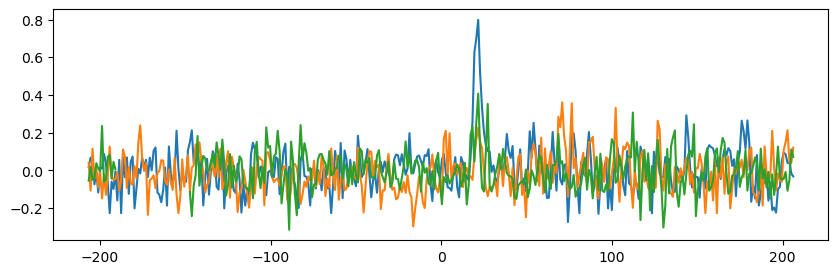

In [23]:
### test loading file and recreating plot:
tab_hdu = fits.open('./'+cube_ID+'_leaf_avg_spectratab_unweighted.fits')[1]
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,3))
ax.plot(tab_hdu.data[cube_ID+'a_velocity_h2co_218.2GHz'][:],
        tab_hdu.data[cube_ID+'a_intensity_h2co_218.2GHz'][:])
ax.plot(tab_hdu.data[cube_ID+'a_velocity_h2co_218.5GHz'][:],
        tab_hdu.data[cube_ID+'a_intensity_h2co_218.5GHz'][:])
ax.plot(tab_hdu.data[cube_ID+'a_velocity_h2co_218.8GHz'][:],
        tab_hdu.data[cube_ID+'a_intensity_h2co_218.8GHz'][:])